In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import time

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd

from gpt3forchem.api_wrappers import (extract_regression_prediction, fine_tune,
                                      query_gpt3, extract_prediction)
from gpt3forchem.data import get_mof_yield_data
from gpt3forchem.input import (create_mof_yield_prompt,
                               get_mof_yield_prompt_completions)

from collections import Counter
from sklearn.metrics import r2_score

from pycm import ConfusionMatrix

In [ ]:
data = get_mof_yield_data()

In [ ]:
prompts = get_mof_yield_prompt_completions(data)

In [ ]:
prompts_without_additive = []

for i, row in prompts.iterrows(): 
    if not 'additive' in row['prompt']: 
        prompts_without_additive.append(row)

In [ ]:
train_prompts, test_prompts = train_test_split(prompts, test_size=0.2)

In [ ]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_mof_yield_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_mof_yield_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [ ]:
model = fine_tune(train_filename, valid_filename)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [ ]:
model

'ada:ft-lsmoepfl-2022-10-12-10-10-53'

In [ ]:
responses = query_gpt3(model, test_prompts)

In [ ]:
predictions = np.array([extract_regression_prediction(responses, i) for i, completion in enumerate(responses["choices"])])

In [ ]:
true= test_prompts['completion'].apply(lambda x: int(x.split('@@@')[0])).values

<matplotlib.collections.PathCollection>

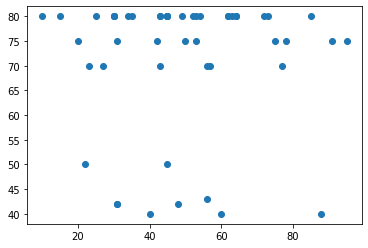

In [ ]:
plt.scatter(true, predictions)

In [ ]:
r2_score(true[~np.isnan(predictions)], predictions[~np.isnan(predictions)])

-1.6300371810490457

In [ ]:
from collections import Counter

In [ ]:
c = Counter(predictions)

In [ ]:
c.most_common()

[(80.0, 26), (75.0, 9), (70.0, 6), (42.0, 3), (40.0, 3), (50.0, 2), (43.0, 1)]

In [ ]:
test_prompts.reset_index()['prompt'].iloc[np.argwhere(predictions==80).flatten()].values

array(['What is the yield of the reaction of the metal Sr with the linker [O-]C(=O)c1cc(cc(c1)S([O])([O])[O])C(=O)O in the solvents 1.0 O at 160 Celsius for 72 hours?',
       'What is the yield of the reaction of the metal Cu with the linker [O-]C(=O)c1ccc(cc1)N1C=CN([CH]1)c1ccc(cc1)C(=O)[O-] in the solvents 1.0 CN1CCCC1=O at 120 Celsius for 20 hours?',
       'What is the yield of the reaction of the metal Cd with the linker [O-]C(=O)c1ccc(cc1c1ccc(cc1)C(=O)[O-])C(=O)[O-] in the solvents 0.04 CN(C)C=O, 0.3 CO, 0.66 O at 150 Celsius for 36 hours?',
       'What is the yield of the reaction of the metal Dy with the linkers [O-]C(=O)c1c2ccccc2c(c2c1cccc2)C(=O)[O-], [O-]C(=O)c1cc(N)c(cc1N)C(=O)[O-] in the solvents 1.0 CN(C)C=O at 95 Celsius for 24 hours?',
       'What is the yield of the reaction of the metal Co with the linker [O-]C(=O)C1SCC(N1)C(=O)[O-] in the solvents 1.0 O at 90 Celsius for 24 hours?',
       'What is the yield of the reaction of the metal Mg with the linker [O-]C(=

### Build a classifier

In [ ]:
data['yield_bin'] = [1 if d > data['yield'].median() else 0 for d in data['yield']]

In [ ]:
Counter(data['yield_bin'])

Counter({1: 219, 0: 222})

In [ ]:
prompts = get_mof_yield_prompt_completions(data, 'yield_bin')

In [ ]:
train_prompts, test_prompts = train_test_split(prompts, test_size=0.2)

In [ ]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_mof_yield_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_mof_yield_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [ ]:
modelname = fine_tune(train_filename, valid_filename)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [ ]:
completions = query_gpt3(modelname, test_prompts)

In [ ]:
completions

{'choices': [<OpenAIObject> JSON: {
    "finish_reason": "length",
    "index": 0,
    "logprobs": null,
    "text": "0@@@@@@@@@C"
  },
  <OpenAIObject> JSON: {
    "finish_reason": "length",
    "index": 1,
    "logprobs": null,
    "text": "0@@@@@@@@@@"
  },
  <OpenAIObject> JSON: {
    "finish_reason": "length",
    "index": 2,
    "logprobs": null,
    "text": "1@@@@@@@@@@"
  },
  <OpenAIObject> JSON: {
    "finish_reason": "length",
    "index": 3,
    "logprobs": null,
    "text": "1@@@@@@@@@@@"
  },
  <OpenAIObject> JSON: {
    "finish_reason": "length",
    "index": 4,
    "logprobs": null,
    "text": "1@@@@@@@@@@"
  },
  <OpenAIObject> JSON: {
    "finish_reason": "length",
    "index": 5,
    "logprobs": null,
    "text": "0@@@@@@@@@@"
  },
  <OpenAIObject> JSON: {
    "finish_reason": "length",
    "index": 6,
    "logprobs": null,
    "text": "0@@@@@@@@@@"
  },
  <OpenAIObject> JSON: {
    "finish_reason": "length",
    "index": 7,
    "logprobs": null,
    "text": "0@@@@@

In [ ]:
predictions = np.array([extract_prediction(completions, i) for i, completion in enumerate(completions["choices"])])

In [ ]:
true = test_prompts['completion'].apply(lambda x: x.split('@@@')[0]).values

In [ ]:
cm = ConfusionMatrix(true, predictions)

In [ ]:
print(cm)

Predict  0        1        
Actual
0        25       22       

1        22       20       





Overall Statistics : 

95% CI                                                            (0.40174,0.60949)
ACC Macro                                                         0.50562
ARI                                                               -0.0113
AUNP                                                              0.50405
AUNU                                                              0.50405
Bangdiwala B                                                      0.25799
Bennett S                                                         0.01124
CBA                                                               0.50405
CSI                                                               0.00811
Chi-Squared                                                       0.00585
Chi-Squared DF                                                    1
Conditional Entropy                                           